In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Collab code to mount drive**

In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
#creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
#vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 155639 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.27-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=%7Bcreds.client_id%7D&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=%7Bcreds.client_id%7D&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdr

In [ ]:
%matplotlib inline

In [ ]:
!mkdir -p drive
!google-drive-ocamlfuse drive


/usr/bin/xdg-open: 851: /usr/bin/xdg-open: www-browser: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: links2: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: elinks: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: links: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: lynx: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: w3m: not found
xdg-open: no method available for opening 'https://accounts.google.com/o/oauth2/auth?client_id=%7Bcreds.client_id%7D&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force'
/bin/sh: 1: firefox: not found
/bin/sh: 1: google-chrome: not found
/bin/sh: 1: chromium-browser: not found
/bin/sh: 1: open: not found
Error: Error opening URL:https://accounts.google.com/o/oauth2/auth?client_id=%7Bcreds.client_id%7D&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=c



```
# This is formatted as code
```

# **Loading libraries**

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math
import pickle
from torch.autograd import Variable

USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

*Load* & Preprocess Data




In [ ]:
corpus_name = "/content/drive/MyDrive/Datasets/ALLDataset"
corpus = os.path.join("data", corpus_name)

def printLines(file, n=10):
    with open(file, 'rb') as datafile:
        lines = datafile.readlines()
    for line in lines[:n]:
        print(line)

printLines(os.path.join(corpus, "movie_lines.txt"))

b'L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!\n'
b'L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!\n'
b'L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I hope so.\n'
b'L984 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ She okay?\n'
b"L925 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Let's go.\n"
b'L924 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ Wow\n'
b"L872 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Okay -- you're gonna need to learn how to lie.\n"
b'L871 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ No\n'
b'L870 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I\'m kidding.  You know how sometimes you just become this "persona"?  And you don\'t know how to quit?\n'
b'L869 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Like my fear of wearing pastels?\n'


 Create formatted data file



In [ ]:
# Splits each line of the file into a dictionary of fields
def loadLines(fileName, fields):
    lines = {}
    with open(fileName, 'r', encoding='iso-8859-1') as f:
        for line in f:
            values = line.split(" +++$+++ ")
            # Extract fields
            lineObj = {}
            for i, field in enumerate(fields):
                lineObj[field] = values[i]
            lines[lineObj['lineID']] = lineObj
    return lines


# Groups fields of lines from `loadLines` into conversations based on *movie_conversations.txt*
def loadConversations(fileName, lines, fields):
    conversations = []
    with open(fileName, 'r', encoding='iso-8859-1') as f:
        for line in f:
            values = line.split(" +++$+++ ")
            # Extract fields
            convObj = {}
            for i, field in enumerate(fields):
                convObj[field] = values[i]
            utterance_id_pattern = re.compile('L[0-9]+')
            lineIds = utterance_id_pattern.findall(convObj["utteranceIDs"])
            # Reassemble lines
            convObj["lines"] = []
            for lineId in lineIds:
                convObj["lines"].append(lines[lineId])
            conversations.append(convObj)
    return conversations


# Extracts pairs of sentences from conversations
def extractSentencePairs(conversations):
    qa_pairs = []
    for conversation in conversations:
        # Iterate over all the lines of the conversation
        for i in range(len(conversation["lines"]) - 1):  # We ignore the last line (no answer for it)
            inputLine = conversation["lines"][i]["text"].strip()
            targetLine = conversation["lines"][i+1]["text"].strip()
            # Filter wrong samples (if one of the lists is empty)
            if inputLine and targetLine:
                qa_pairs.append([inputLine, targetLine])
    return qa_pairs

In [ ]:
# Define path to new file
datafile = os.path.join(corpus, "formatted_movie_lines2.txt")

delimiter = '\t'
# Unescape the delimiter
delimiter = str(codecs.decode(delimiter, "unicode_escape"))

# Initialize lines dict, conversations list, and field ids
lines = {}
conversations = []
MOVIE_LINES_FIELDS = ["lineID", "characterID", "movieID", "character", "text"]
MOVIE_CONVERSATIONS_FIELDS = ["character1ID", "character2ID", "movieID", "utteranceIDs"]

# Load lines and process conversations
print("\nProcessing corpus...")
lines = loadLines(os.path.join(corpus, "/content/drive/MyDrive/Datasets/ALLDataset/movie_lines.txt"), MOVIE_LINES_FIELDS)
print("\nLoading conversations...")
conversations = loadConversations(os.path.join(corpus, "/content/drive/MyDrive/Datasets/ALLDataset/movie_conversations.txt"),
                                  lines, MOVIE_CONVERSATIONS_FIELDS)

# Write new csv file
print("\nWriting newly formatted file...")
with open(datafile, 'w', encoding='utf-8') as outputfile:
    writer = csv.writer(outputfile, delimiter=delimiter, lineterminator='\n')
    for pair in extractSentencePairs(conversations):
        writer.writerow(pair)

# Print a sample of lines
print("\nSample lines from file:")
printLines(datafile)


Processing corpus...

Loading conversations...

Writing newly formatted file...

Sample lines from file:
b"Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.\tWell, I thought we'd start with pronunciation, if that's okay with you.\n"
b"Well, I thought we'd start with pronunciation, if that's okay with you.\tNot the hacking and gagging and spitting part.  Please.\n"
b"Not the hacking and gagging and spitting part.  Please.\tOkay... then how 'bout we try out some French cuisine.  Saturday?  Night?\n"
b"You're asking me out.  That's so cute. What's your name again?\tForget it.\n"
b"No, no, it's my fault -- we didn't have a proper introduction ---\tCameron.\n"
b"Cameron.\tThe thing is, Cameron -- I'm at the mercy of a particularly hideous breed of loser.  My sister.  I can't date until she does.\n"
b"The thing is, Cameron -- I'm at the mercy of a particularly hideous breed of loser.  My sister.  I can't dat



```
# This is formatted as code
```

# **Vocabulary Class**

In [ ]:
# Default word tokens
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token

class Voc:
    def __init__(self):        
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count SOS, EOS, PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3 # Count default tokens

        for word in keep_words:
            self.addWord(word)

# **Custom functions to preprocess Strings**

In [ ]:
# Importing modules
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet') 
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
'''
POS
'''
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
 
str= '''My name is Tony Stark and I am Iron Man. '''
words = word_tokenize(str)
postag = pos_tag(words)
print(postag)

[('My', 'PRP$'), ('name', 'NN'), ('is', 'VBZ'), ('Tony', 'NNP'), ('Stark', 'NNP'), ('and', 'CC'), ('I', 'PRP'), ('am', 'VBP'), ('Iron', 'NNP'), ('Man', 'NNP'), ('.', '.')]


In [ ]:
'''
POS
'''
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

In [ ]:
'''
POS
'''


from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
lemmatizer = WordNetLemmatizer()
sentence = "The striped bats are hanging on their feet for best"
print([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(sentence)])



sentence = "you know what i mean"
print([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(sentence)])

sentence ="william - he asked me to meet him here."
print([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(sentence)])

['The', 'strip', 'bat', 'be', 'hang', 'on', 'their', 'foot', 'for', 'best']
['you', 'know', 'what', 'i', 'mean']
['william', '-', 'he', 'ask', 'me', 'to', 'meet', 'him', 'here', '.']


In [ ]:
MAX_LENGTH = 10  # Maximum sentence length to consider

# Python program to convert a list to string
# Function to convert  
def listToString(s): 
    # initialize an empty string
    str1 = "" 
    # traverse in the string  
    for ele in s: 
        str1 += ele 
        str1 +=' ' 
    # return string  
    return str1


def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )
# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    #print("s   ",s)
    s = re.sub(r"i'm", r"i am", s)
    s = re.sub(r"he's", r"he is", s)
    s = re.sub(r"she's", r"she is", s)
    s = re.sub(r"it's", r"it is", s)
    s = re.sub(r"that's", r"that is", s)
    s = re.sub(r"what's", r"what is", s)
    s = re.sub(r"where's", r"where is", s)
    s = re.sub(r"\'s", r" is", s)
    s = re.sub(r"\'ll", r" will", s)
    s = re.sub(r"\'ve", r" have", s)
    s = re.sub(r"\'re", r" are", s)
    s = re.sub(r"\'d", r" would", s)
    s = re.sub(r"won't", r"will not", s)
    s = re.sub(r"don't", r"do not", s)
    s = re.sub(r"didn't", r"did not", s)
    s = re.sub(r"doesn't", r"does not", s)
    s = re.sub(r"can't", r"can not", s)
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    s = re.sub(r"[-()\"“”:)#/@;:<>{}+=~|.?,]😊🙂☺️❤️❓.", r"", s)
    word_list = nltk.word_tokenize(s)
    #print(word_list)
    lemmatizer = WordNetLemmatizer()   
    # an instance of Word Net Lemmatizer
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in word_list] 
    s = listToString(lemmatized_words)
    #print('*******************')

    return s

# Read query/response pairs and return a voc object
def readVocs(datafile):
    print("Reading lines...")    
    # Read the file and split into lines
    lines = open(datafile, encoding='utf-8').\
        read().strip().split('\n')
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    voc = Voc()
    return voc, pairs

# Returns True iff both sentences in a pair 'p' are under the MAX_LENGTH threshold
def filterPair(p):
    # Input sequences need to preserve the last word for EOS token
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

# Filter pairs using filterPair condition
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

# Using the functions defined above, return a populated voc object and pairs list
def loadPrepareData(datafile):
    print("Start preparing training data ...")
    voc, pairs = readVocs(datafile)
    print("Read {!s} sentence pairs".format(len(pairs)))
    pairs = filterPairs(pairs)
    print("Trimmed to {!s} sentence pairs".format(len(pairs)))
    print("Counting words...")
    for pair in pairs:
        voc.addSentence(pair[0])
        voc.addSentence(pair[1])
    print("Counted words:", voc.num_words)
    return voc, pairs




# **Reading chat file**


In [ ]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
# Load/Assemble voc and pairs

datafile = '/content/drive/MyDrive/Datasets/ALLDataset/formatted_movie_lines2.txt'
voc, pairs = loadPrepareData(datafile)
# Print some pairs to validate
print("\npairs:")
for pair in pairs[:10]:
    print(pair)

Start preparing training data ...
Reading lines...
Read 221282 sentence pairs
Trimmed to 52667 sentence pairs
Counting words...
Counted words: 13363

pairs:
['there . ', 'where ? ']
['you have my word . a a gentleman ', 'you be sweet . ']
['hi . ', 'look like thing work out tonight huh ? ']
['you know chastity ? ', 'i believe we share an art instructor ']
['have fun tonight ? ', 'ton ']
['but ', 'you always be this selfish ? ']
['do you listen to this crap ? ', 'what crap ? ']
['what good stuff ? ', 'the real you . ']
['the real you . ', 'like my fear of wear pastel ? ']
['wow ', 'let be go . ']



# **2) Filter out pairs with trimmed words.**

In [ ]:
#input_variable

MIN_COUNT = 3    # Minimum word count threshold for trimming

def trimRareWords(voc, pairs, MIN_COUNT):
    # Trim words used under the MIN_COUNT from the voc
    voc.trim(MIN_COUNT)
    # Filter out pairs with trimmed words
    keep_pairs = []
    for pair in pairs:
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        # Check input sentence
        for word in input_sentence.split(' '):
            if word not in voc.word2index:
                keep_input = False
                break
        # Check output sentence
        for word in output_sentence.split(' '):
            if word not in voc.word2index:
                keep_output = False
                break

        # Only keep pairs that do not contain trimmed word(s) in their input or output sentence
        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("Trimmed from {} pairs to {}, {:.4f} of total".format(len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
    return keep_pairs


# Trim voc and pairs
pairs = trimRareWords(voc, pairs, MIN_COUNT)

keep_words 5883 / 13360 = 0.4403
Trimmed from 52667 pairs to 44385, 0.8427 of total


# **Splitting testing and training pairs**


In [ ]:
#testing pairs
testpairs = pairs[450000:]

#Training pairs
pairs  = pairs[:45000]


# **Generating batches**

In [ ]:
def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]


def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

# Returns padded input sequence tensor and lengths
def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths


def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.ByteTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

def batch2TrainData(voc, pair_batch):
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len



small_batch_size = 5
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len = batches


In [ ]:
pair_batch = pairs[:5]
print(pair_batch)
pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
print(pair_batch)
print(target_variable)
print(mask)
print(max_target_len)


[['there . ', 'where ? '], ['you have my word . a a gentleman ', 'you be sweet . '], ['hi . ', 'look like thing work out tonight huh ? '], ['have fun tonight ? ', 'ton '], ['do you listen to this crap ? ', 'what crap ? ']]
[['you have my word . a a gentleman ', 'you be sweet . '], ['do you listen to this crap ? ', 'what crap ? '], ['have fun tonight ? ', 'ton '], ['there . ', 'where ? '], ['hi . ', 'look like thing work out tonight huh ? ']]
tensor([[  43,   25,   18,   49,  101],
        [1876,   36,    9,   91,    4],
        [  56,   57,   12,  218,   40],
        [  56,  604, 3700,   59,   36],
        [  56,  171,   78, 1658,    8],
        [   5,   46,   43,    4,   36],
        [   2,   35, 5024,    5,    7],
        [   0,    4,    5,    2,    5],
        [   0,    5,    2,    0,    2],
        [   0,    2,    0,    0,    0]])
tensor([[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
   

# **Encoder**


In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding
        self.gru = nn.LSTM(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        
        embedded = self.embedding(input_seq)
        
        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        
        outputs, hidden = self.gru(packed, hidden)
        
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        
        return outputs, hidden
    def init_hidden(self):
        
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

# **attention weights**

In [ ]:
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        
    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def forward(self, hidden, encoder_outputs):
        
        attn_energies = self.dot_score(hidden, encoder_outputs)
        attn_energies = attn_energies.t()
        return F.softmax(attn_energies, dim=1).unsqueeze(1)      

# **Decoder**

In [ ]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

       
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.LSTM(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))#, bidirectional=True)
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.attn = Attn(attn_model, hidden_size)
    
    def forward(self, input_step, last_hidden, encoder_outputs):
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        rnn_output, hidden = self.gru(embedded, last_hidden)
        attn_weights = self.attn(rnn_output, encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        return output, hidden

# Define Training Procedure



In [ ]:
def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

# **Train Function**

In [ ]:
def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding,
          encoder_optimizer, decoder_optimizer, batch_size, clip, max_length=MAX_LENGTH):

    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

  
    input_variable = input_variable.to(device)
    lengths = lengths.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)

    # Lengths for rnn packing should always be on the cpu
    lengths = lengths.to("cpu")
    
    loss = 0
    print_losses = []
    n_totals = 0

    
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    
    decoder_hidden = encoder_hidden[:decoder.n_layers]
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            
            decoder_input = target_variable[t].view(1, -1)
            
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

    
    loss.backward()

    
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals

# **Training iterations**



In [ ]:
def fun1(pairs):
  global m
  global s
  #for p in pairs:
  if m>=len(pairs):
    m=0
    s+=1
  m+=1
  #print(s,m-1,len(pairs),pairs[m-1])
  return pairs[m-1]
m=0
s=1

def trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size, print_every, save_every, clip, corpus_name, loadFilename):

    # Load batches for each iteration

    training_batches = [batch2TrainData(voc, [fun1(pairs) for _ in range(batch_size)])
                      for _ in range(n_iteration)]

    print('number of epoch  {}'.format(s))
#    training_batches = [batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
#                      for _ in range(n_iteration)]

    # Initializations
    print('Initializing ...')
    
    start_iteration = 1
    print_loss = 0
    losslist = []
    if loadFilename:
        start_iteration = checkpoint['iteration'] + 1

    
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch = training_batches[iteration - 1]
        
        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        
        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip)
        print_loss += loss

        # Print progress
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0
            losslist.append(print_loss_avg)

        # Save checkpoint
        if (iteration % save_every == 0):
            directory = os.path.join(save_dir, model_name, corpus_name, '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size))
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                'iteration': iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                'en_opt': encoder_optimizer.state_dict(),
                'de_opt': decoder_optimizer.state_dict(),
                'loss': loss,
                'voc_dict': voc.__dict__,
                'embedding': embedding.state_dict()
            }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))
    return losslist

# **Evaluate my text**






In [ ]:
def evaluate(encoder, decoder, searcher, voc, sentence, max_length=MAX_LENGTH):
  
    indexes_batch = [indexesFromSentence(voc, sentence)]
    
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    
    input_batch = input_batch.to(device)
    #*******lengths = lengths.to(device)
    
    lengths = lengths.to("cpu")
    
    tokens, scores = searcher(input_batch, lengths, max_length)
    
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words

'''
Dep=0
def evaluateInput(encoder, decoder, searcher, voc):
    input_sentence = ''
    global Dep
    while(1):
        try:
            # Get input sentence
            input_sentence = input('You :   ')

            Dep+=fD2(input_sentence)
            #vs = analyzer.polarity_scores(input_sentence)
            mm=scaleD(input_sentence)
            #print("Scale.{}".format(mm))
            
            # Check if it is quit case
            if input_sentence == 'q' or input_sentence == 'quit' or input_sentence == 'bye' : break
            # Normalize sentence
            input_sentence = normalizeString(input_sentence)
            # Evaluate sentence
            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
            # Format and print response sentence
            output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            print('Bot :   ', ' '.join(output_words))
            
            #print('Diagnos {}'.format(Dep))

        except KeyError:
            print("Error: Encountered unknown word.")
    if(Dep>5):
      Rscale(mm)
      print('Diagnos {}'.format(Dep))
    else:
      print(" >>  your psychological state is great, you are fine. ^^ ")
'''

'\nDep=0\ndef evaluateInput(encoder, decoder, searcher, voc):\n    input_sentence = \'\'\n    global Dep\n    while(1):\n        try:\n            # Get input sentence\n            input_sentence = input(\'You :   \')\n\n            Dep+=fD2(input_sentence)\n            #vs = analyzer.polarity_scores(input_sentence)\n            mm=scaleD(input_sentence)\n            #print("Scale.{}".format(mm))\n            \n            # Check if it is quit case\n            if input_sentence == \'q\' or input_sentence == \'quit\' or input_sentence == \'bye\' : break\n            # Normalize sentence\n            input_sentence = normalizeString(input_sentence)\n            # Evaluate sentence\n            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)\n            # Format and print response sentence\n            output_words[:] = [x for x in output_words if not (x == \'EOS\' or x == \'PAD\')]\n            print(\'Bot :   \', \' \'.join(output_words))\n            \n     

# **Beam Decoder**

In [ ]:
class Sentence:
    def __init__(self, decoder_hidden, last_idx=SOS_token, sentence_idxes=[], sentence_scores=[]):
        if(len(sentence_idxes) != len(sentence_scores)):
            raise ValueError("length of indexes and scores should be the same")
        self.decoder_hidden = decoder_hidden
        self.last_idx = last_idx
        self.sentence_idxes =  sentence_idxes
        self.sentence_scores = sentence_scores

    def avgScore(self):
        if len(self.sentence_scores) == 0:
            raise ValueError("Calculate average score of sentence, but got no word")
        # return mean of sentence_score
        return sum(self.sentence_scores) / len(self.sentence_scores)

    def addTopk(self, topi, topv, decoder_hidden, beam_size, voc):
        topv = torch.log(topv)
        terminates, sentences = [], []
        for i in range(beam_size):
            if topi[0][i] == EOS_token:
                terminates.append(([voc.index2word[idx.item()] for idx in self.sentence_idxes] + ['<EOS>'],
                                   self.avgScore())) 
                continue
            idxes = self.sentence_idxes[:] 
            scores = self.sentence_scores[:] 
            idxes.append(topi[0][i])
            scores.append(topv[0][i])
            sentences.append(Sentence(decoder_hidden, topi[0][i], idxes, scores))
        return terminates, sentences

    def toWordScore(self, voc):
        
        words = []
        for i in range(len(self.sentence_idxes)):
            if self.sentence_idxes[i] == EOS_token:
                words.append('<EOS>')
            else:
                words.append(voc.index2word[self.sentence_idxes[i].item()])
       
        if self.sentence_idxes[-1] != EOS_token:
            words.append('<EOS>')
        return (words, self.avgScore())

    def __repr__(self):
        res = f"Sentence with indices {self.sentence_idxes} "
        res += f"and scores {self.sentence_scores}"
        return res
def beam_decode(decoder, decoder_hidden, encoder_outputs, voc, beam_size, max_length=MAX_LENGTH):
    terminal_sentences, prev_top_sentences, next_top_sentences = [], [], []
    prev_top_sentences.append(Sentence(decoder_hidden))
    for i in range(max_length):
        
        for sentence in prev_top_sentences:
            decoder_input = torch.LongTensor([[sentence.last_idx]])
            decoder_input = decoder_input.to(device)

            decoder_hidden = sentence.decoder_hidden
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(beam_size)
            term, top = sentence.addTopk(topi, topv, decoder_hidden, beam_size, voc)
            terminal_sentences.extend(term)
            next_top_sentences.extend(top)
           
        
        next_top_sentences.sort(key=lambda s: s.avgScore(), reverse=True)
        prev_top_sentences = next_top_sentences[:beam_size]
        next_top_sentences = []
        

    terminal_sentences += [sentence.toWordScore(voc) for sentence in prev_top_sentences]
    terminal_sentences.sort(key=lambda x: x[1], reverse=True)

    n = min(len(terminal_sentences), 15)
    return terminal_sentences[:n]
  
class BeamSearchDecoder(nn.Module):

    def __init__(self, encoder, decoder, voc, beam_size=10):
        super(BeamSearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.voc = voc
        self.beam_size = beam_size

    def forward(self, input_seq, input_length, max_length):
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        
        decoder_hidden = encoder_hidden[:self.decoder.n_layers]
        
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        sentences = beam_decode(self.decoder, decoder_hidden, encoder_outputs, self.voc, self.beam_size, max_length)
        
        
        all_tokens = [torch.tensor(self.voc.word2index.get(w, 0)) for w in sentences[0][0]]
        return all_tokens, None

    def __str__(self):
        res = f"BeamSearchDecoder with beam size {self.beam_size}"
        return res


# **Run Model**


In [ ]:
model_name = 'try Final flask '
attn_model = 'dot'
save_dir = '/content/drive/MyDrive/'
corpus_name="trian5"

hidden_size = 512
encoder_n_layers = 2
decoder_n_layers = 4
dropout = 0.5
batch_size = 256 
loadFilename = None
checkpoint_iter = 10000
'''
loadFilename = os.path.join(save_dir, model_name, corpus_name,
                            '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size),
                            '{}_checkpoint.tar'.format(checkpoint_iter))'''


# Load model if a loadFilename is provided
if loadFilename:
    # If loading on same machine the model was trained on
    #checkpoint = torch.load(loadFilename)
    # If loading a model trained on GPU to CPU
    checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    embedding_sd = checkpoint['embedding']
    voc.__dict__ = checkpoint['voc_dict']

print('Building encoder and decoder ...')
embedding = nn.Embedding(voc.num_words, hidden_size)
if loadFilename:
    embedding.load_state_dict(embedding_sd)

# Initialize encoder & decoder models
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)

if loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)
# Use appropriate device

encoder = encoder.to(device)
decoder = decoder.to(device)

print('Models built and ready to go!')

Building encoder and decoder ...
Models built and ready to go!


In [ ]:
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iteration = 10000
print_every = 10
save_every = 2000
loadFilename = None
checkpoint_iter = 10000

encoder.train()
decoder.train()
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
print("Starting Training!")
lossvalues = trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
           embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
           print_every, save_every, clip, corpus_name, loadFilename)


Starting Training!
number of epoch  58
Initializing ...
Training...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:28.)
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py:175: UserWarning: masked_scatter_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/cuda/IndexKernel.cpp:62.)
  allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to run the backward pass


Iteration: 10; Percent complete: 0.1%; Average loss: 7.7138
Iteration: 20; Percent complete: 0.2%; Average loss: 5.2014
Iteration: 30; Percent complete: 0.3%; Average loss: 4.4948
Iteration: 40; Percent complete: 0.4%; Average loss: 4.4455
Iteration: 50; Percent complete: 0.5%; Average loss: 4.3537
Iteration: 60; Percent complete: 0.6%; Average loss: 4.3397
Iteration: 70; Percent complete: 0.7%; Average loss: 4.1693
Iteration: 80; Percent complete: 0.8%; Average loss: 4.2312
Iteration: 90; Percent complete: 0.9%; Average loss: 4.1648
Iteration: 100; Percent complete: 1.0%; Average loss: 4.1479
Iteration: 110; Percent complete: 1.1%; Average loss: 4.0656
Iteration: 120; Percent complete: 1.2%; Average loss: 3.9877
Iteration: 130; Percent complete: 1.3%; Average loss: 3.7870
Iteration: 140; Percent complete: 1.4%; Average loss: 3.7430
Iteration: 150; Percent complete: 1.5%; Average loss: 3.6746
Iteration: 160; Percent complete: 1.6%; Average loss: 3.6457
Iteration: 170; Percent complete:

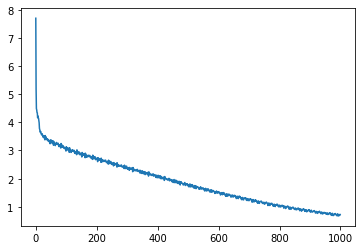

In [ ]:
import matplotlib.pyplot as plt

plt.plot(lossvalues)
plt.show()


# **Bleu score Calculation** 



In [ ]:
'''# Set dropout layers to eval mode
encoder.eval()
decoder.eval()

# Initialize search module
from nltk.translate.bleu_score import sentence_bleu,corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction


searcher = BeamSearchDecoder(encoder, decoder, voc, 10)
gram1_bleu_score = []
gram2_bleu_score = []
for i in range(0,len(testpairs),1):
  
  input_sentence = testpairs[i][0]
  
  reference = testpairs[i][1:]
  templist = []
  for k in range(len(reference)):
    if(reference[k]!=''):
      temp = reference[k].split(' ')
      templist.append(temp)
  
  
  input_sentence = normalizeString(input_sentence)
  output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
  output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
  chencherry = SmoothingFunction()
  score1 = sentence_bleu(templist,output_words,weights=(1, 0, 0, 0) ,smoothing_function=chencherry.method1)
  score2 = sentence_bleu(templist,output_words,weights=(0.5, 0.5, 0, 0),smoothing_function=chencherry.method1) 
  gram1_bleu_score.append(score1)
  gram2_bleu_score.append(score2)
  if i%1000 == 0:
    print(i,sum(gram1_bleu_score)/len(gram1_bleu_score),sum(gram2_bleu_score)/len(gram2_bleu_score))
print("Total Bleu Score for 1 grams on testing pairs: ", sum(gram1_bleu_score)/len(gram1_bleu_score))  
print("Total Bleu Score for 2 grams on testing pairs: ", sum(gram2_bleu_score)/len(gram2_bleu_score)) '''

'# Set dropout layers to eval mode\nencoder.eval()\ndecoder.eval()\n\n# Initialize search module\nfrom nltk.translate.bleu_score import sentence_bleu,corpus_bleu\nfrom nltk.translate.bleu_score import SmoothingFunction\n\n\nsearcher = BeamSearchDecoder(encoder, decoder, voc, 10)\ngram1_bleu_score = []\ngram2_bleu_score = []\nfor i in range(0,len(testpairs),1):\n  \n  input_sentence = testpairs[i][0]\n  \n  reference = testpairs[i][1:]\n  templist = []\n  for k in range(len(reference)):\n    if(reference[k]!=\'\'):\n      temp = reference[k].split(\' \')\n      templist.append(temp)\n  \n  \n  input_sentence = normalizeString(input_sentence)\n  output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)\n  output_words[:] = [x for x in output_words if not (x == \'EOS\' or x == \'PAD\')]\n  chencherry = SmoothingFunction()\n  score1 = sentence_bleu(templist,output_words,weights=(1, 0, 0, 0) ,smoothing_function=chencherry.method1)\n  score2 = sentence_bleu(templist,output_wor

In [ ]:
'''import matplotlib.pyplot as plt

plt.plot(gram1_bleu_score)
plt.show()'''

'import matplotlib.pyplot as plt\n\nplt.plot(gram1_bleu_score)\nplt.show()'

In [ ]:
'''import matplotlib.pyplot as plt

plt.plot(gram2_bleu_score)
plt.show()'''


'import matplotlib.pyplot as plt\n\nplt.plot(gram2_bleu_score)\nplt.show()'

# **diagnosis**

In [ ]:
#print ("chatbot: Hello there! How are you doing?")

#text = input("You: ")
import csv
import numpy as np
import pandas as pd
import nltk
from nltk import sent_tokenize
from nltk import word_tokenize
import nltk
nltk.download('punkt')

#D ='/content/drive/MyDrive/Data/D.csv'

#with open('/content/drive/MyDrive/Data/D.csv', mode='r') as f:
    #V1 = csv.DictReader(f)

'''
file = open('/content/drive/MyDrive/Data/D.csv')
csvreader = csv.reader(file)
header = []
header = next(csvreader)
V1=[]
for V2 in csvreader:
    V1.append(V2)
print("************")
print(V1)
file.close()
'''

'''
with open('/content/drive/MyDrive/Data/D.csv', 'rb') as file:
    content = file.readlines()
header = content[:1]
rows = content[1:]
print(header)
print(rows)
'''

'''
V1=[]
with open('/content/drive/MyDrive/Data/Mayaar.csv', 'rb') as f:
  for i in range(411):
    v1 = f.readline()
    V1.append(v1)
print(V1)
'''

'''
with open('/content/D.csv', encoding="utf8", errors='ignore') as f:
  for i in range(411):
    v1 = f.readline()
    V1.append(v1)
print(V1)
'''
'''
V1=[]
with open('/content/drive/MyDrive/Data/D.txt', 'rb') as file:
    content = file.readlines()
header = content[:1]
rows = content[1:]
print(content)
print(header)
print(rows)
'''

'''
data = pd.read_csv('/content/D.csv')
data = data[(data['diagnosis'] != '[deleted]')]
'''


'''
from google.colab import files
uploaded = files.upload()
import io
df2 = pd.read_csv(io.BytesIO(uploaded['D.csv']))# Dataset is now stored in a Pandas Dataframe
'''

#link = 'https://drive.google.com/file/d/1cPCgGPpQ6bM_1yl0vKBo0t17OH0kGOBU/view?usp=sharing'




'''
def fD1(z,text):
    sentences = sent_tokenize(input_sentence)
    for s in sentences:
        if (s in V1):
            #global x
            z+=1
        else:
            z+=0
    words = word_tokenize(input_sentence)
    for w in words:
        if (w in V1):
            z+=1 
        else:
            z+=0
    return z
'''
'''
V1=[]
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/Data/Mayaar.csv',header=1)
#data.head()
#data = data[(data['diagnosis'] != '[deleted]')]
print(len(data))
for i in range(len(data)):
  V1.append(data[i])
print(V1)
'''
'''
import csv
V1=[]
with open('/content/drive/MyDrive/Data/Mayaar.csv', newline='') as f:
    reader = csv.reader(f)
    V1 = list(reader)

print(V1)




def fD2(input_sentence):
    global x
    #print ("chatbot: are you have any problem else?")
    #text = input("You: ")

    z=0
    #c=fD1(z,input_sentence)

    sentences = sent_tokenize(input_sentence)
    for s in sentences:
        if (s in V1):
            #global x
            z+=1
            print("z1{}".format(z))
        else:
            z+=0
            print("z2{}".format(z))
    words = word_tokenize(input_sentence)
    for w in words:
        if (w in V1):
            z+=1 
            print("z3{}".format(z))
        else:
            z+=0
            print("z4{}".format(z))
    #print('x: {}'.format(x))
    #fD2()
    if(z>1):
        print("Are the Symptoms from 6 months?  ( YES or NO ) ")
        text = input("You: ")
        if(text=="yes"):

          x+=z
          #print("chatbot: go to scal")
        else:
          #print("you are fine")
          z=0      
    #else:
      #print("you are fine")
          return z

x=0
'''

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


'\nimport csv\nV1=[]\nwith open(\'/content/drive/MyDrive/Data/Mayaar.csv\', newline=\'\') as f:\n    reader = csv.reader(f)\n    V1 = list(reader)\n\nprint(V1)\n\n\n\n\ndef fD2(input_sentence):\n    global x\n    #print ("chatbot: are you have any problem else?")\n    #text = input("You: ")\n\n    z=0\n    #c=fD1(z,input_sentence)\n\n    sentences = sent_tokenize(input_sentence)\n    for s in sentences:\n        if (s in V1):\n            #global x\n            z+=1\n            print("z1{}".format(z))\n        else:\n            z+=0\n            print("z2{}".format(z))\n    words = word_tokenize(input_sentence)\n    for w in words:\n        if (w in V1):\n            z+=1 \n            print("z3{}".format(z))\n        else:\n            z+=0\n            print("z4{}".format(z))\n    #print(\'x: {}\'.format(x))\n    #fD2()\n    if(z>1):\n        print("Are the Symptoms from 6 months?  ( YES or NO ) ")\n        text = input("You: ")\n        if(text=="yes"):\n\n          x+=z\n        

In [ ]:
'''
import csv
V1=[]
with open('/content/drive/MyDrive/Data/Mayaar.csv', newline='') as f:
    reader = csv.reader(f)
    V1 = list(reader)

print(V1)

def fD2(input_sentence):
    global x
    z=0
    sentences = sent_tokenize(input_sentence)
    for s in sentences:
        if (s in V1):
            z+=1
            print("z1{}".format(z))
        else:
            z+=0
            print("z2{}".format(z))
    words = word_tokenize(input_sentence)
    for w in words:
        if (w in V1):
            z+=1 
            print("z3{}".format(z))
        else:
            z+=0
            print("z4{}".format(z))
    if(z>1):
        print("Are the Symptoms from 6 months?  ( YES or NO ) ")
        text = input("You: ")
        if(text=="yes"):
          return z
x=0
'''

'\nimport csv\nV1=[]\nwith open(\'/content/drive/MyDrive/Data/Mayaar.csv\', newline=\'\') as f:\n    reader = csv.reader(f)\n    V1 = list(reader)\n\nprint(V1)\n\ndef fD2(input_sentence):\n    global x\n    z=0\n    sentences = sent_tokenize(input_sentence)\n    for s in sentences:\n        if (s in V1):\n            z+=1\n            print("z1{}".format(z))\n        else:\n            z+=0\n            print("z2{}".format(z))\n    words = word_tokenize(input_sentence)\n    for w in words:\n        if (w in V1):\n            z+=1 \n            print("z3{}".format(z))\n        else:\n            z+=0\n            print("z4{}".format(z))\n    if(z>1):\n        print("Are the Symptoms from 6 months?  ( YES or NO ) ")\n        text = input("You: ")\n        if(text=="yes"):\n          return z\nx=0\n'

In [ ]:
V1=[]
import csv
with open('/content/drive/MyDrive/Datasets/ALLDataset/new_dataset.csv', 'r') as file:
    reader = csv.reader(file)
    print(reader)
    for row in reader:
      for i in row:
        V1.append(i)
print("#########")
print(V1)
'''
def fD2(input_sentence):
    global x
    z=0
    sentences = sent_tokenize(input_sentence)
    for s in sentences:
        if (s in V1):
            z+=1
            #print("z1{}".format(z))
        else:
            z+=0
            #print("z2{}".format(z))
    words = word_tokenize(input_sentence)
    for w in words:
        if (w in V1):
            z+=1 
            #print("z3{}".format(z))
        else:
            z+=0
            #print("z4{}".format(z))
    if(z>=1):
        print("Are the Symptoms from 6 months?  ( YES or NO ) ")
        text = input("You: ")
        if(text=="yes" or text=="YES"):
          return z
        else:
           return 0
    else:
      return 0
x=0

'''


#########
['diagnosis', 'Loss of desire to engage in normal daily activities', 'Feeling of nervousness and depression', 'feeling of nervousness', 'feeling of melancholy', 'Depression', 'nervousness', 'melancholy', 'sorrow', 'bleakness', 'isolation', 'hopelessness', 'Feeling of hopelessness', 'crying for no reason', 'Feeling of hopelessness', 'cry', 'Bouts of crying for no apparent reason', 'sleep disturbances', 'Difficulties concentrating', 'Difficulties in making decisions', 'Unintentional weight gain', 'weight gain', 'Unintentional weight loss', 'weight loss', 'uptight', 'nervous', 'Anxiety and boredom', 'boredom', 'restless', 'worried', 'Anxiety', 'Exessive sensitivity', 'Feeling of tiredness or weakness', 'Feeling of worthlessness', 'Loss of desire for sex', 'suicidal thoughts', 'suicide attempts', 'tiredness', 'weakness', 'worthlessness', 'self-murder', 'commit suicide', 'destroy oneself', 'suicide', 'make away of myself', 'make away with myself', 'attempts to commit suicide', 'Un

'\ndef fD2(input_sentence):\n    global x\n    z=0\n    sentences = sent_tokenize(input_sentence)\n    for s in sentences:\n        if (s in V1):\n            z+=1\n            #print("z1{}".format(z))\n        else:\n            z+=0\n            #print("z2{}".format(z))\n    words = word_tokenize(input_sentence)\n    for w in words:\n        if (w in V1):\n            z+=1 \n            #print("z3{}".format(z))\n        else:\n            z+=0\n            #print("z4{}".format(z))\n    if(z>=1):\n        print("Are the Symptoms from 6 months?  ( YES or NO ) ")\n        text = input("You: ")\n        if(text=="yes" or text=="YES"):\n          return z\n        else:\n           return 0\n    else:\n      return 0\nx=0\n\n'

VADER

In [ ]:
!pip install -q vaderSentiment

     |████████████████████████████████| 125 kB 4.6 MB/s 


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

#def text_sentiment_vader(text):
# vs = analyzer.polarity_scores(text)
# return int(vs.get("compound"))
 
## predictions = df_test.tweet.map(lambda x : text_sentiment_vader(x))

In [ ]:
#input_sentence = input('You :   ')
#vs = analyzer.polarity_scores(input_sentence)
#print(vs)

#vs['neg']*100, "% Negative")


In [ ]:
##text = input('You :   ')
#v=text_sentiment_vader(input_sentence)
#print(v)

In [ ]:
'''scale=0
#input_sentence = input('You :   ')
#vs = analyzer.polarity_scores(input_sentence)
def scaleD(input_sentence):
  global scale
  vs = analyzer.polarity_scores(input_sentence)
  ##print(vs)
  n=vs['neg']
  neu=vs['neu']
  p=vs['pos']
  if(n>=0.75):
    scale+=3
  elif((n>=0.45)&(n<0.75)):
    scale+=2
  elif((n<0.45)&(n!=0)):
    scale+=1
  else:
    scale+=0
  return scale
def Rscale(scale):
  if(scale<=10):
    print("These ups and downs are considered normal ---> {}".format(scale))
  elif((scale>=11)&(scale<=16)):
    print("Mild mood disturbance ---> {}".format(scale))
  elif((scale>=17)&(scale<=20)):
    print("Borderline clinical depression ---> {}".format(scale))
  elif((scale>=21)&(scale<=30)):
    print("Moderate depression ---> {}".format(scale))
  elif((scale>=31)&(scale<=40)):
    print("Severe depression ---> {}".format(scale))
  else:
    print("Extreme depression ---> {}".format(scale))



  #print(scale)'''

'scale=0\n#input_sentence = input(\'You :   \')\n#vs = analyzer.polarity_scores(input_sentence)\ndef scaleD(input_sentence):\n  global scale\n  vs = analyzer.polarity_scores(input_sentence)\n  ##print(vs)\n  n=vs[\'neg\']\n  neu=vs[\'neu\']\n  p=vs[\'pos\']\n  if(n>=0.75):\n    scale+=3\n  elif((n>=0.45)&(n<0.75)):\n    scale+=2\n  elif((n<0.45)&(n!=0)):\n    scale+=1\n  else:\n    scale+=0\n  return scale\ndef Rscale(scale):\n  if(scale<=10):\n    print("These ups and downs are considered normal ---> {}".format(scale))\n  elif((scale>=11)&(scale<=16)):\n    print("Mild mood disturbance ---> {}".format(scale))\n  elif((scale>=17)&(scale<=20)):\n    print("Borderline clinical depression ---> {}".format(scale))\n  elif((scale>=21)&(scale<=30)):\n    print("Moderate depression ---> {}".format(scale))\n  elif((scale>=31)&(scale<=40)):\n    print("Severe depression ---> {}".format(scale))\n  else:\n    print("Extreme depression ---> {}".format(scale))\n\n\n\n  #print(scale)'

In [ ]:
'''Dep=0
def evaluateInput(encoder, decoder, searcher, voc):
    input_sentence = ''
    global Dep
    while(1):
        try:
            # Get input sentence
            input_sentence = input('You :   ')

            Dep+=fD2(input_sentence)
            #vs = analyzer.polarity_scores(input_sentence)
            mm=scaleD(input_sentence)
            #print("Scale.{}".format(mm))
            
            # Check if it is quit case
            if input_sentence == 'q' or input_sentence == 'quit' or input_sentence == 'bye' : break
            # Normalize sentence
            input_sentence = normalizeString(input_sentence)
            # Evaluate sentence
            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
            # Format and print response sentence
            output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            print('Bot :   ', ' '.join(output_words))
            
            #print('Diagnos {}'.format(Dep))

        except KeyError:
            print("Error: Encountered unknown word.")
    if(Dep>5):
      Rscale(mm)
      print('Diagnos {}'.format(Dep))
    else:
      print(" >>  your psychological state is great, you are fine. ^^ ")'''

'Dep=0\ndef evaluateInput(encoder, decoder, searcher, voc):\n    input_sentence = \'\'\n    global Dep\n    while(1):\n        try:\n            # Get input sentence\n            input_sentence = input(\'You :   \')\n\n            Dep+=fD2(input_sentence)\n            #vs = analyzer.polarity_scores(input_sentence)\n            mm=scaleD(input_sentence)\n            #print("Scale.{}".format(mm))\n            \n            # Check if it is quit case\n            if input_sentence == \'q\' or input_sentence == \'quit\' or input_sentence == \'bye\' : break\n            # Normalize sentence\n            input_sentence = normalizeString(input_sentence)\n            # Evaluate sentence\n            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)\n            # Format and print response sentence\n            output_words[:] = [x for x in output_words if not (x == \'EOS\' or x == \'PAD\')]\n            print(\'Bot :   \', \' \'.join(output_words))\n            \n       

In [ ]:
'''def fD2(input_sentence):
    global x
    z=0
    sentences = sent_tokenize(input_sentence)
    for s in sentences:
        if (s in V1):
            z+=1
            #print("z1{}".format(z))
        else:
            z+=0
            #print("z2{}".format(z))
    words = word_tokenize(input_sentence)
    for w in words:
        if (w in V1):
            z+=1 
            #print("z3{}".format(z))
        else:
            z+=0
            #print("z4{}".format(z))
    if(z>=1):
        print("Are the Symptoms from 6 months?  ( YES or NO ) ")
        text = input("You: ")
        if(text=="yes" or text=="YES"):
          return z
        else:
           return 0
    else:
      return 0
x=0
'''

'def fD2(input_sentence):\n    global x\n    z=0\n    sentences = sent_tokenize(input_sentence)\n    for s in sentences:\n        if (s in V1):\n            z+=1\n            #print("z1{}".format(z))\n        else:\n            z+=0\n            #print("z2{}".format(z))\n    words = word_tokenize(input_sentence)\n    for w in words:\n        if (w in V1):\n            z+=1 \n            #print("z3{}".format(z))\n        else:\n            z+=0\n            #print("z4{}".format(z))\n    if(z>=1):\n        print("Are the Symptoms from 6 months?  ( YES or NO ) ")\n        text = input("You: ")\n        if(text=="yes" or text=="YES"):\n          return z\n        else:\n           return 0\n    else:\n      return 0\nx=0\n'

In [ ]:
'''scale=0
#input_sentence = input('You :   ')
#vs = analyzer.polarity_scores(input_sentence)
def scaleD(input_sentence):
  global scale
  vs = analyzer.polarity_scores(input_sentence)
  ##print(vs)
  n=vs['neg']
  neu=vs['neu']
  p=vs['pos']
  if(n>=0.75):
    scale+=3
  elif((n>=0.45)&(n<0.75)):
    scale+=2
  elif((n<0.45)&(n!=0)):
    scale+=1
  else:
    scale+=0
  return scale
def Rscale(scale):
  if(scale<=10):
    print("These ups and downs are considered normal ---> {}".format(scale))
  elif((scale>=11)&(scale<=16)):
    print("Mild mood disturbance ---> {}".format(scale))
  elif((scale>=17)&(scale<=20)):
    print("Borderline clinical depression ---> {}".format(scale))
  elif((scale>=21)&(scale<=30)):
    print("Moderate depression ---> {}".format(scale))
  elif((scale>=31)&(scale<=40)):
    print("Severe depression ---> {}".format(scale))
  else:
    print("Extreme depression ---> {}".format(scale))

'''

'scale=0\n#input_sentence = input(\'You :   \')\n#vs = analyzer.polarity_scores(input_sentence)\ndef scaleD(input_sentence):\n  global scale\n  vs = analyzer.polarity_scores(input_sentence)\n  ##print(vs)\n  n=vs[\'neg\']\n  neu=vs[\'neu\']\n  p=vs[\'pos\']\n  if(n>=0.75):\n    scale+=3\n  elif((n>=0.45)&(n<0.75)):\n    scale+=2\n  elif((n<0.45)&(n!=0)):\n    scale+=1\n  else:\n    scale+=0\n  return scale\ndef Rscale(scale):\n  if(scale<=10):\n    print("These ups and downs are considered normal ---> {}".format(scale))\n  elif((scale>=11)&(scale<=16)):\n    print("Mild mood disturbance ---> {}".format(scale))\n  elif((scale>=17)&(scale<=20)):\n    print("Borderline clinical depression ---> {}".format(scale))\n  elif((scale>=21)&(scale<=30)):\n    print("Moderate depression ---> {}".format(scale))\n  elif((scale>=31)&(scale<=40)):\n    print("Severe depression ---> {}".format(scale))\n  else:\n    print("Extreme depression ---> {}".format(scale))\n\n'

# **Chatting with BOT / Evaluation**


In [ ]:
'''scale=0
Dep=0
z=0
con=0
status = False
executed_word = list()
def evaluateInput(encoder, decoder, searcher, voc):
  global Dep
  global status
  global scale
  global z
    #input_sentence =str(request.args['msg'])    
   # input_sentence = request.args['msg']
  input_sentence=""     
  willAnalysisWord  = ""
  while(1):
    try:
      input_sentence=input('You :   ')
      executed_word.append(input_sentence)

      sentences = sent_tokenize(input_sentence)
      for s in sentences:
        if (s in V1):
          z+=1
            
        else:
          z+=0
            
      words = word_tokenize(input_sentence)
      for w in words:
        if (w in V1):
          z+=1 
                
        else:
          z+=0
                
                  
            
                    
      if(z>=1 or status):
        if(status==False):
          status =True  
          print("Are the Symptoms from 6 months?  ( YES or NO ) ")
          #print("--------------------- " + str(executed_word[-1].lower().strip().startswith("y")))
        if(executed_word[-1].lower().strip().startswith("y")):
          status =False
          Dep+= z
                          
                          
          willAnalysisWord = executed_word[-2]
          print("TheWillAnalysis1= "+willAnalysisWord)                  


        else:
          willAnalysisWord="no"
                      
      else:
        willAnalysisWord=executed_word[-1]
                  
                  
      print("TheWillAnalysis2= "+willAnalysisWord)        
      vs = analyzer.polarity_scores(willAnalysisWord)
                    
      n=vs['neg']
      neu=vs['neu']
      p=vs['pos']
      if(n>=0.75):
        scale+=3
      elif((n>=0.45)&(n<0.75)):
        scale+=2
      elif((n<0.45)&(n!=0)):
        scale+=1
      else:
        scale+=0
              
      mm=scale
                    ### END FUN ###
      z=0
                    #print("Scale.{}".format(mm))
                  
                    # Check if it is quit case
      print("the input= "+input_sentence)
      if input_sentence == 'q' or input_sentence == 'quit' or input_sentence == 'bye' : break
                    # Normalize sentence
      input_sentence = normalizeString(input_sentence)
                    # Evaluate sentence
      output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
                    # Format and print response sentence
      output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
      print('Bot :   ', ' '.join(output_words))
                  
                    #print('Diagnos {}'.format(Dep))
      
      
    except KeyError:
      print("Error: Encountered unknown word.")
  if(Dep>5):
              ## DONE ## Rscale(mm)
    print("iam dep=5")
              ### Rscale() ###
    if(mm<=10):
      print("These ups and downs are considered normal ---> {}".format(mm))
    elif((mm>=11)&(mm<=16)):
      print("Mild mood disturbance ---> {}".format(mm))
    elif((mm>=17)&(mm<=20)):
      print("Borderline clinical depression ---> {}".format(mm))
    elif((mm>=21)&(mm<=30)):
      print("Moderate depression ---> {}".format(mm))
    elif((mm>=31)&(mm<=40)):
      print("Severe depression ---> {}".format(mm))
    else:
      print("Extreme depression ---> {}".format(mm))
              ### END FUN ###
      
    print('Diagnos {}'.format(Dep))
  else:
    print(" >>  your psychological state is great, you are fine. ^^ ")'''

'scale=0\nDep=0\nz=0\ncon=0\nstatus = False\nexecuted_word = list()\ndef evaluateInput(encoder, decoder, searcher, voc):\n  global Dep\n  global status\n  global scale\n  global z\n    #input_sentence =str(request.args[\'msg\'])    \n   # input_sentence = request.args[\'msg\']\n  input_sentence=""     \n  willAnalysisWord  = ""\n  while(1):\n    try:\n      input_sentence=input(\'You :   \')\n      executed_word.append(input_sentence)\n\n      sentences = sent_tokenize(input_sentence)\n      for s in sentences:\n        if (s in V1):\n          z+=1\n            \n        else:\n          z+=0\n            \n      words = word_tokenize(input_sentence)\n      for w in words:\n        if (w in V1):\n          z+=1 \n                \n        else:\n          z+=0\n                \n                  \n            \n                    \n      if(z>=1 or status):\n        if(status==False):\n          status =True  \n          print("Are the Symptoms from 6 months?  ( YES or NO ) ")\n    

In [ ]:
encoder.eval()
decoder.eval()
searcher = BeamSearchDecoder(encoder, decoder, voc, 10)
#evaluateInput(encoder, decoder, searcher, voc)

In [ ]:
!pip install flask-ngrok
!curl -s https://ngrok-agent.s3.amazonaws.com/ngrok.asc | sudo tee /etc/apt/trusted.gpg.d/ngrok.asc >/dev/null && echo "deb https://ngrok-agent.s3.amazonaws.com buster main" | sudo tee /etc/apt/sources.list.d/ngrok.list && sudo apt update && sudo apt install ngrok
!ngrok config add-authtoken 2B8yu5knwniusufYLnquMje1plh_8cNfEB9WXD4KbJCbmyCT
!pip install pyngrok           

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
deb https://ngrok-agent.s3.amazonaws.com buster main
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 https://ngrok-agent.s3.amazonaws.com buster InRelease [20.3 kB]
Hit:9 http://ppa.launchpad.net/alessandro-strada/ppa/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/cran/libgit

In [ ]:
port_no = 5000

In [ ]:
scale=0
Dep=0
z=0
con=0
status = False
executed_word = list()
import json
from flask import Flask, request
#from flask_ngrok import run_with_ngrok
from pyngrok import ngrok
app = Flask(__name__)
ngrok.set_auth_token("2B8yu5knwniusufYLnquMje1plh_8cNfEB9WXD4KbJCbmyCT")
public_url =  ngrok.connect(port_no).public_url

@app.route('/api')
def get_bot_reponse():
  d={}
  


  user_text=  request.args['msg']
  def evaluateInput(encoder, decoder, searcher, voc,input_sentence):
    global Dep
    global status
    global scale
    global z
    #input_sentence =str(request.args['msg'])    
   # input_sentence = request.args['msg']
         
    willAnalysisWord  = ""
    while(1):
      try:
        executed_word.append(input_sentence)

        sentences = sent_tokenize(input_sentence)
        for s in sentences:
          if (s in V1):
            z+=1
            
          else:
            z+=0
            
        words = word_tokenize(input_sentence)
        for w in words:
          if (w in V1):
            z+=1 
                
          else:
            z+=0
                
                  
            
                    
        if(z>=1 or status):
          if(status==False):
            status =True  
            return("Are the Symptoms from 6 months?  ( YES or NO ) ")
          #print("--------------------- " + str(executed_word[-1].lower().strip().startswith("y")))
          if(executed_word[-1].lower().strip().startswith("yes")):
            status =False
            Dep+= z
                          
                          
            willAnalysisWord = executed_word[-2]
                          


          else:
            willAnalysisWord="no"
                      
        else:
          willAnalysisWord=executed_word[-1]
                  
                  
              
        vs = analyzer.polarity_scores(willAnalysisWord)
                    
        n=vs['neg']
        neu=vs['neu']
        p=vs['pos']
        if(n>=0.75):
          scale+=3
        elif((n>=0.45)&(n<0.75)):
          scale+=2
        elif((n<0.45)&(n!=0)):
          scale+=1
        else:
          scale+=0
              
        mm=scale
                    ### END FUN ###
        z=0
                    #print("Scale.{}".format(mm))
                  
                    # Check if it is quit case
        print("the input= "+input_sentence)
        if input_sentence == 'q' or input_sentence == 'quit' or input_sentence == 'bye' : break
                    # Normalize sentence
        input_sentence = normalizeString(willAnalysisWord)
                    # Evaluate sentence
        output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
                    # Format and print response sentence
        output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
        return(' '.join(output_words))
                  
                    #print('Diagnos {}'.format(Dep))
      
      
      except KeyError:
        return("Error: Encountered unknown word.")
    if(Dep>5):
              ## DONE ## Rscale(mm)
      print("iam dep=5")
              ### Rscale() ###
      if(mm<=10):
        return("These ups and downs are considered normal ---> {}".format(mm))
      elif((mm>=11)&(mm<=16)):
        return("Mild mood disturbance ---> {}".format(mm))
      elif((mm>=17)&(mm<=20)):
        return("Borderline clinical depression ---> {}".format(mm))
      elif((mm>=21)&(mm<=30)):
        return("Moderate depression ---> {}".format(mm))
      elif((mm>=31)&(mm<=40)):
        return("Severe depression ---> {}".format(mm))
      else:
        return("Extreme depression ---> {}".format(mm))
              ### END FUN ###
      
      return('Diagnos {}'.format(Dep))
    else:
      return(" >>  your psychological state is great, you are fine. ^^ ")

  #answer=str(evaluateInput(encoder, decoder, searcher, voc))
  answer=evaluateInput(encoder, decoder, searcher, voc,user_text)
    
  d=answer
  #d=" ".join( d['output'])
  print(d)
  #print( d['output'])
  #stri  =json.dumps( d['output'])
  #print("Stri "+ stri)
  #listToStr = ' '.join([(elem) for elem in stri])
  #listToStr = ' '.join(map(str, stri))
  '''d=d['listToStr'].replace(',', '')
  d=d.replace(' ', '')
  d=d.replace('[', '')
  d=d.replace(']', '')
  d=d.replace("'", ' ')
  d=d.replace('"', '')
  d=d.replace('.', '')  
  #print("final mess "+d)'''
  #d=d.replace(' ', '')
  
  return (d)
  

print(f"To access the link please click {public_url}")
#if __name__ == "__main__":
#app.run(debug=True)
app.run(port=port_no)
    

To access the link please click http://ecd5-35-225-119-205.ngrok.io
 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


the input= hi


127.0.0.1 - - [01/Jul/2022 18:57:46] "GET /api?msg=hi HTTP/1.1" 200 -


hi . . . . . rose . 


127.0.0.1 - - [01/Jul/2022 18:57:47] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [01/Jul/2022 18:57:57] "GET /api?msg=i%20am%20feeling%20sad HTTP/1.1" 200 -


Are the Symptoms from 6 months?  ( YES or NO ) 
the input= yes


127.0.0.1 - - [01/Jul/2022 18:58:03] "GET /api?msg=yes HTTP/1.1" 200 -


yeah . . . 
the input= i need some help


127.0.0.1 - - [01/Jul/2022 18:58:15] "GET /api?msg=i%20need%20some%20help HTTP/1.1" 200 -


young one 
the input= How are you?


127.0.0.1 - - [01/Jul/2022 18:58:24] "GET /api?msg=How%20are%20you? HTTP/1.1" 200 -


fine . how be you ? 


127.0.0.1 - - [01/Jul/2022 18:58:36] "GET /api?msg=i%20want%20to%20cry HTTP/1.1" 200 -


Are the Symptoms from 6 months?  ( YES or NO ) 
the input= yes


127.0.0.1 - - [01/Jul/2022 18:58:41] "GET /api?msg=yes HTTP/1.1" 200 -


i want to go . 
the input= i am feeling the life is end


127.0.0.1 - - [01/Jul/2022 18:58:59] "GET /api?msg=i%20am%20feeling%20the%20life%20is%20end HTTP/1.1" 200 -


bullshit . 
the input= i hate my self


127.0.0.1 - - [01/Jul/2022 18:59:15] "GET /api?msg=i%20hate%20my%20self HTTP/1.1" 200 -


you do not even know you . 
the input= i want kill my self


127.0.0.1 - - [01/Jul/2022 18:59:32] "GET /api?msg=i%20want%20kill%20my%20self HTTP/1.1" 200 -


that be a deal . 


127.0.0.1 - - [01/Jul/2022 18:59:51] "GET /api?msg=i%20need%20to%20cry%20and%20stay%20alone HTTP/1.1" 200 -


Are the Symptoms from 6 months?  ( YES or NO ) 
the input= yes


127.0.0.1 - - [01/Jul/2022 19:00:00] "GET /api?msg=yes HTTP/1.1" 200 -


where be you go ? 


127.0.0.1 - - [01/Jul/2022 19:00:52] "GET /api?msg=i%20will%20go%20to%20any%20where,%20i%20am%20feeling%20sad HTTP/1.1" 200 -


Are the Symptoms from 6 months?  ( YES or NO ) 
the input= yes


127.0.0.1 - - [01/Jul/2022 19:00:58] "GET /api?msg=yes HTTP/1.1" 200 -


no . 


127.0.0.1 - - [01/Jul/2022 19:01:07] "GET /api?msg=i%20will%20cry HTTP/1.1" 200 -


Are the Symptoms from 6 months?  ( YES or NO ) 
the input= yes


127.0.0.1 - - [01/Jul/2022 19:01:12] "GET /api?msg=yes HTTP/1.1" 200 -


no you will not . 
the input= are you my friend?


127.0.0.1 - - [01/Jul/2022 19:02:07] "GET /api?msg=are%20you%20my%20friend? HTTP/1.1" 200 -


yes . 
the input= i hate you


127.0.0.1 - - [01/Jul/2022 19:02:14] "GET /api?msg=i%20hate%20you HTTP/1.1" 200 -


i do not know . 


127.0.0.1 - - [01/Jul/2022 19:02:29] "GET /api?msg=iam%20feeling%20depressed HTTP/1.1" 200 -


Are the Symptoms from 6 months?  ( YES or NO ) 


127.0.0.1 - - [01/Jul/2022 19:02:34] "GET /api?msg=yes HTTP/1.1" 200 -


the input= yes
Error: Encountered unknown word.
the input= hi


127.0.0.1 - - [01/Jul/2022 19:07:03] "GET /api?msg=hi HTTP/1.1" 200 -


hi . . . . . rose . 
the input= how are you?


127.0.0.1 - - [01/Jul/2022 19:07:11] "GET /api?msg=how%20are%20you? HTTP/1.1" 200 -


fine . how be you ? 


127.0.0.1 - - [01/Jul/2022 19:07:25] "GET /api?msg=i%20am%20not%20fine%20,%20i%20need%20to%20cry HTTP/1.1" 200 -


Are the Symptoms from 6 months?  ( YES or NO ) 
the input= yes


127.0.0.1 - - [01/Jul/2022 19:07:28] "GET /api?msg=yes HTTP/1.1" 200 -


fine ! 


127.0.0.1 - - [01/Jul/2022 19:07:44] "GET /api?msg=no%20,%20i%20want%20to%20cry HTTP/1.1" 200 -


Are the Symptoms from 6 months?  ( YES or NO ) 
the input= yes


127.0.0.1 - - [01/Jul/2022 19:07:48] "GET /api?msg=yes HTTP/1.1" 200 -


no you do not . 
the input= i hate my self


127.0.0.1 - - [01/Jul/2022 19:07:56] "GET /api?msg=i%20hate%20my%20self HTTP/1.1" 200 -


you do not even know you . 
the input= are you my friend?


127.0.0.1 - - [01/Jul/2022 19:08:19] "GET /api?msg=are%20you%20my%20friend? HTTP/1.1" 200 -


yes . 
the input= okay, thank you bye


127.0.0.1 - - [01/Jul/2022 19:08:33] "GET /api?msg=okay,%20thank%20you%20bye HTTP/1.1" 200 -


thank you . 


127.0.0.1 - - [01/Jul/2022 19:08:37] "GET /api?msg=q HTTP/1.1" 200 -


the input= q
iam dep=5
Moderate depression ---> 22
